# Final Project - Security Analytics
## Microsoft Malware Classfication

### Authors: 
* Kandarp Khandwala (kkhandw1) and 
* Antara Sargam (asargam1)


### Data: 
* Set of known malware files representing a mix of 9 different families. Each malware file has an Id, a 20 character hash value uniquely identifying the file, and a Class, an integer representing one of 9 family names to which the malware may belong 
        Ramnit
        Lollipop
        Kelihos_ver3
        Vundo
        Simda
        Tracur
        Kelihos_ver1
        Obfuscator.ACY
        Gatak
        

### Tasks: 
* Develop the best mechanism for classifying files into their respective family affiliations.

### Files
* train.7z - the raw data for the data set
* trainLabels.csv - the class labels associated with the training set

In [47]:
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import zipfile
from io import BytesIO
import lief 
import hashlib

import pandas as pd
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.feature_extraction import FeatureHasher

import numpy as np
import os
import pickle
import io
import re
import glob

In [2]:
datadir = '/datadrive/'
traindir = 'train/'
asmext = '.asm'
byext = '.bytes'

In [3]:
dt = np.dtype([('Id', 'a30'), ('Class', 'u2')])
data = np.loadtxt("trainLabels.csv", skiprows=1, delimiter = ",", dtype=dt)

In [4]:
data

array([(b'"01kcPWA9K2BOxQeS5Rju"', 1), (b'"04EjIdbPV5e1XroFOpiN"', 1),
       (b'"05EeG39MTRrI6VY21DPd"', 1), (b'"05rJTUWYAKNegBk2wE8X"', 1),
       (b'"0AnoOZDNbPXIr2MRBSCJ"', 1), (b'"0AwWs42SUQ19mI7eDcTC"', 1),
       (b'"0cH8YeO15ZywEhPrJvmj"', 1), (b'"0DNVFKwYlcjO7bTfJ5p1"', 1),
       (b'"0DqUX5rkg3IbMY6BLGCE"', 1), (b'"0eaNKwluUmkYdIvZ923c"', 1),
       (b'"0fHVZKeTE6iRb1PIQ4au"', 1), (b'"0G4hwobLuAzvl1PWYfmd"', 1),
       (b'"0gkj92oIleU4SYiCWpaM"', 1), (b'"0H63jydvIahOVqgx5Kfo"', 1),
       (b'"jLr0lyA1TeugxId7Fk2S"', 2), (b'"JLrOfGem93RVtBySioNx"', 2),
       (b'"jMHviQAUXJqEbokeVZYg"', 2), (b'"JmRCrDBGEzfgISdvNsF7"', 2),
       (b'"JMSXw23bN7gKfCeWAxVY"', 2), (b'"jn4ALqJUE9u8TPRyd6t5"', 2),
       (b'"JnCS8Oh4fUmciFgN5IZ3"', 2), (b'"JNfrKZYIEmpVDBzn1kvL"', 2),
       (b'"jnKkElPsxcIaUFhQb8Jd"', 2), (b'"JNP8y5lG7OuK4oq9xhaI"', 2),
       (b'"JNrlKDpRFXhP6wcQjMna"', 2), (b'"JNtLaKBbDMqwTAyCXWzQ"', 2),
       (b'"JnysZFLMzgC4rQDtW7pB"', 2), (b'"jO3ktp4CTZ8Voy2cHJUB"', 2),
      

In [5]:
X = np.zeros((data.shape[0], 4))
y = data['Class']

# Feature Extraction

### Feature 1 - File size

In [6]:
for i, (Id, Class) in enumerate(data):
    X[i][0] = os.path.getsize(datadir + traindir + Id[1:-1].decode("utf-8") + asmext)
    X[i][1] = os.path.getsize(datadir + traindir + Id[1:-1].decode("utf-8") + byext)

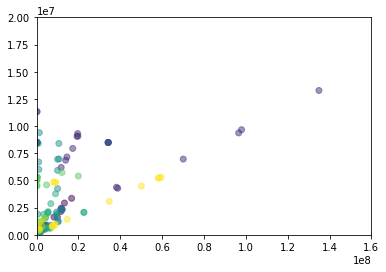

In [7]:
plt.axis((0,1.6*10**8, 0, 2*10**7))
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5)
plt.show()

### Feature 2 - Compressed File Size

In [8]:
def getcompressedsize(fpath):
    inMemoryOutputFile = BytesIO()
    zf = zipfile.ZipFile(inMemoryOutputFile, 'w') 
    zf.write(fpath, compress_type=zipfile.ZIP_DEFLATED)
    s = float(zf.infolist()[0].compress_size)
    zf.close()
    return s

In [9]:
for i, (Id, Class) in enumerate(data):
    print("Processed file {}".format(i))
    X[i][2] = getcompressedsize(datadir + traindir + Id[1:-1].decode("utf-8") + asmext)
    X[i][3] = getcompressedsize(datadir + traindir + Id[1:-1].decode("utf-8") + asmext)

Processed file 0
Processed file 1
Processed file 2
Processed file 3
Processed file 4
Processed file 5
Processed file 6
Processed file 7
Processed file 8
Processed file 9
Processed file 10
Processed file 11
Processed file 12
Processed file 13
Processed file 14
Processed file 15
Processed file 16
Processed file 17
Processed file 18
Processed file 19
Processed file 20
Processed file 21
Processed file 22
Processed file 23
Processed file 24
Processed file 25
Processed file 26
Processed file 27
Processed file 28
Processed file 29
Processed file 30
Processed file 31
Processed file 32
Processed file 33
Processed file 34
Processed file 35
Processed file 36
Processed file 37
Processed file 38
Processed file 39
Processed file 40
Processed file 41
Processed file 42
Processed file 43
Processed file 44
Processed file 45
Processed file 46
Processed file 47
Processed file 48
Processed file 49
Processed file 50
Processed file 51
Processed file 52
Processed file 53
Processed file 54
Processed file 55
Pr

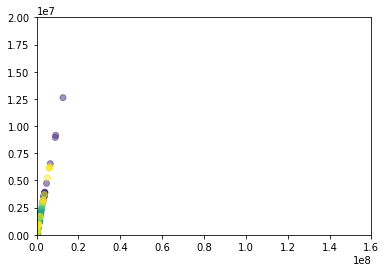

In [10]:
plt.axis((0,1.6*10**8, 0, 2*10**7))
plt.scatter(X[:,2], X[:,3], c=y, alpha=0.5)
plt.show()

### Feature 3 - TFIDF matrix of the contents of asm files over 2-gram

In [34]:
def make_corpus(asm_files):
    for i, file in enumerate(asm_files):
        print('Processed file {}'.format(i))
        yield open(file, 'rb')

In [41]:
import string
from nltk.corpus import stopwords
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char.decode("utf-8") for char in mess if char.decode("utf-8") not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.decode("utf-8").lower() not in stopwords.words('english')]


In [49]:
asmfiles = []
for i, (Id, Class) in enumerate(data):
    asmfiles.append(datadir + traindir + Id[1:-1].decode("utf-8") + asmext)

hv_transformer = HashingVectorizer(input='file', decode_error='replace',
                                      n_features = 10000, stop_words='english',
                                      ngram_range=(2, 2))

In [50]:
asm_corpus = make_corpus(asmfiles)

In [51]:
asm_ngram = hv_transformer.transform(asm_corpus)

Processed file 0
Processed file 1
Processed file 2
Processed file 3
Processed file 4
Processed file 5
Processed file 6
Processed file 7
Processed file 8
Processed file 9
Processed file 10
Processed file 11
Processed file 12
Processed file 13
Processed file 14
Processed file 15
Processed file 16
Processed file 17
Processed file 18
Processed file 19
Processed file 20
Processed file 21
Processed file 22
Processed file 23
Processed file 24
Processed file 25
Processed file 26
Processed file 27
Processed file 28
Processed file 29
Processed file 30
Processed file 31
Processed file 32
Processed file 33
Processed file 34
Processed file 35
Processed file 36
Processed file 37
Processed file 38
Processed file 39
Processed file 40
Processed file 41
Processed file 42
Processed file 43
Processed file 44
Processed file 45
Processed file 46
Processed file 47
Processed file 48
Processed file 49
Processed file 50
Processed file 51
Processed file 52
Processed file 53
Processed file 54
Processed file 55
Pr

AttributeError: 'HashingVectorizer' object has no attribute 'get_feature_names'

In [52]:
print('Shape of Sparse Matrix: ', asm_ngram.shape)
print('Amount of Non-Zero occurences: ', asm_ngram.nnz)
print('Sparsity: %.2f%%' % (100.0 * asm_ngram.nnz / (asm_ngram.shape[0] * asm_ngram.shape[1])))

Shape of Sparse Matrix:  (134, 10000)
Amount of Non-Zero occurences:  1252765
Sparsity: 93.49%


In [53]:
X = np.append(X, asm_ngram.toarray(), axis = 1)
X.shape

(134, 10004)

### Feature 4 -  String file characteristics: urls, directories, registries, headers, entropy, etc. 

In [54]:
class FeatureType(object):
    ''' Base class from which each feature type may inherit '''

    name = ''
    dim = 0

    def __repr__(self):
        return '{}({})'.format(self.name, self.dim)

    def raw_features(self, bytez, lief_binary):
        ''' Generate a JSON-able representation of the file '''
        raise (NotImplemented)

    def process_raw_features(self, raw_obj):
        ''' Generate a feature vector from the raw features '''
        raise (NotImplemented)

    def feature_vector(self, bytez, lief_binary):
        ''' Directly calculate the feature vector from the sample itself. This should only be implemented differently
        if there are significant speedups to be gained from combining the two functions. '''
        return self.process_raw_features(self.raw_features(bytez, lief_binary))

class StringExtractor(FeatureType):
    ''' Extracts strings from raw byte stream '''

    name = 'strings'
    dim = 1 + 1 + 1 + 96 + 1 + 1 + 1 + 1 + 1

    def __init__(self):
        super(FeatureType, self).__init__()
        # all consecutive runs of 0x20 - 0x7f that are 5+ characters
        self._allstrings = re.compile(b'[\x20-\x7f]{5,}')
        # occurances of the string 'C:\'.  Not actually extracting the path
        self._paths = re.compile(b'c:\\\\', re.IGNORECASE)
        # occurances of http:// or https://.  Not actually extracting the URLs
        self._urls = re.compile(b'https?://', re.IGNORECASE)
        # occurances of the string prefix HKEY_.  No actually extracting registry names
        self._registry = re.compile(b'HKEY_')
        # crude evidence of an MZ header (dropper?) somewhere in the byte stream
        self._mz = re.compile(b'MZ')

    def raw_features(self, bytez, lief_binary):
        allstrings = self._allstrings.findall(bytez)
        if allstrings:
            # statistics about strings:
            string_lengths = [len(s) for s in allstrings]
            avlength = sum(string_lengths) / len(string_lengths)
            # map printable characters 0x20 - 0x7f to an int array consisting of 0-95, inclusive
            as_shifted_string = [b - ord(b'\x20') for b in b''.join(allstrings)]
            c = np.bincount(as_shifted_string, minlength=96)  # histogram count
            # distribution of characters in printable strings
            csum = c.sum()
            p = c.astype(np.float32) / csum
            wh = np.where(c)[0]
            H = np.sum(-p[wh] * np.log2(p[wh]))  # entropy
        else:
            avlength = 0
            c = np.zeros((96,), dtype=np.float32)
            H = 0
            csum = 0

        return {
            'numstrings': len(allstrings),
            'avlength': avlength,
            'printabledist': c.tolist(),  # store non-normalized histogram
            'printables': int(csum),
            'entropy': float(H),
            'paths': len(self._paths.findall(bytez)),
            'urls': len(self._urls.findall(bytez)),
            'registry': len(self._registry.findall(bytez)),
            'MZ': len(self._mz.findall(bytez))
        }

    def process_raw_features(self, raw_obj):
        hist_divisor = float(raw_obj['printables']) if raw_obj['printables'] > 0 else 1.0
        return np.hstack([
            raw_obj['numstrings'], raw_obj['avlength'], raw_obj['printables'],
            np.asarray(raw_obj['printabledist']) / hist_divisor, raw_obj['entropy'], raw_obj['paths'], raw_obj['urls'],
            raw_obj['registry'], raw_obj['MZ']
        ]).astype(np.float32)


In [55]:
all_features = []
extractor = StringExtractor()
for i, (Id, Class) in enumerate(data):
    print("Processed file {}".format(i))
    file = datadir + traindir + Id[1:-1].decode("utf-8") + asmext
    with open(file, 'rb') as f:
        bytez = f.read()
        f.close()
    features = extractor.raw_features(bytez, None)
    all_features.append(extractor.process_raw_features(features))

string_features = np.array(all_features)

Processed file 0
Processed file 1
Processed file 2
Processed file 3
Processed file 4
Processed file 5
Processed file 6
Processed file 7
Processed file 8
Processed file 9
Processed file 10
Processed file 11
Processed file 12
Processed file 13
Processed file 14
Processed file 15
Processed file 16
Processed file 17
Processed file 18
Processed file 19
Processed file 20
Processed file 21
Processed file 22
Processed file 23
Processed file 24
Processed file 25
Processed file 26
Processed file 27
Processed file 28
Processed file 29
Processed file 30
Processed file 31
Processed file 32
Processed file 33
Processed file 34
Processed file 35
Processed file 36
Processed file 37
Processed file 38
Processed file 39
Processed file 40
Processed file 41
Processed file 42
Processed file 43
Processed file 44
Processed file 45
Processed file 46
Processed file 47
Processed file 48
Processed file 49
Processed file 50
Processed file 51
Processed file 52
Processed file 53
Processed file 54
Processed file 55
Pr

In [56]:
X = np.append(X, string_features, axis = 1)
X.shape

(134, 10108)

## Split into train and test

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(107, 10108) (107,)
(27, 10108) (27,)


## Run ExtraTreesClassifier on the Dataset
* The ExtraTreesClassifier is similar to RandomForestClassifier but cheaper to train from a computational point of view but can grow much bigger. We try this to get a quick overview of our results

In [58]:
et_clf = ExtraTreesClassifier(n_estimators=2000, max_features=None, min_samples_leaf=1,
        min_samples_split=9, n_jobs=1, criterion='gini')
et_clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=9,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:
y_prob = et_clf.predict_proba(X_test)
y_pred = et_clf.predict(X_test)
print("Logarithmic Loss: {}".format(log_loss(y_test, y_prob)))
print("Predicted Probability using ExtraTreesClassifier: {}".format(y_prob))

ValueError: y_true and y_pred contain different number of classes 9, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [1 2 3 4 5 6 7 8 9]

## Perform 5-fold cross validation

In [60]:
y_pred = cross_val_predict(et_clf, X, y, cv=5)
print('Cross-validated predictions: ', y_pred)

Cross-validated predictions:  [1 1 1 1 1 1 1 1 1 1 1 1 8 1 9 2 2 2 2 2 1 2 2 2 2 2 2 2 8 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 3 5 8 5 5 5 5 8 7 5 5 5
 6 6 6 6 6 9 1 6 1 5 6 6 6 6 6 7 9 7 7 7 7 7 7 7 7 9 9 7 7 7 8 8 8 8 8 8 8
 5 8 8 8 8 8 8 8 9 8 9 9 9 9 9 9 2 9 9 6 6 9 9]


In [62]:
y_scores = cross_val_score(et_clf, X, y, cv=5, scoring='accuracy')
print('Cross-validated accuracy scores: ', y_scores)
print('Mean cross-validated accuracy scores: ', y_scores.mean())

Cross-validated accuracy scores:  [0.92592593 0.88888889 0.81481481 0.77777778 0.88461538]
Mean cross-validated accuracy scores:  0.8584045584045583
